In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("Helsinki-NLP/opus-100", "en-id")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/132k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_data = dataset['train']
train_data = train_data.shuffle(seed=42).select(range(100000))

val_data = dataset['validation']
test_data = dataset['test']

print(train_data[0])

{'translation': {'en': '♪ Ch-ch-ch-ch-changes', 'id': '♪ Ch-ch-ch-ch-changes ♪'}}


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
source_lang = "en"
target_lang = "id"
prefix = "translate English to Indonesian: "

def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=60, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=60, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_data = train_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
tokenized_val = val_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

In [ ]:
batch_size = 32

learning_rate = 2e-5

In [ ]:
tf_train_set = tokenized_data.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_val_set = tokenized_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [ ]:
from transformers import create_optimizer, AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=0.01)

In [ ]:
model.compile(optimizer=optimizer)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/t5_checkpoints"  # Save checkpoints in Google Drive
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
import tensorflow as tf

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch}.h5"),
    save_weights_only=True,
    save_freq="epoch",
)

In [ ]:
# Load from the latest checkpoint
def load_latest_checkpoint(model, checkpoint_dir):
    checkpoints = [ckpt for ckpt in os.listdir(checkpoint_dir) if ckpt.endswith(".h5")]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split("_")[2].split(".")[0]))
        model.load_weights(os.path.join(checkpoint_dir, latest_checkpoint))
        print(f"Loaded weights from checkpoint: {latest_checkpoint}")
    else:
        print("No checkpoint found. Starting training from scratch.")

load_latest_checkpoint(model, checkpoint_dir)

No checkpoint found. Starting training from scratch.


In [ ]:
history = model.fit(
    x=tf_train_set,
    validation_data=tf_val_set,
    epochs=10,
    callbacks=[checkpoint_callback],
)

Epoch 1/10
3125/3125 [==============================] - 906s 281ms/step - loss: 3.4546 - val_loss: 2.8678
Epoch 2/10
3125/3125 [==============================] - 852s 273ms/step - loss: 2.8810 - val_loss: 2.5461
Epoch 3/10
3125/3125 [==============================] - 857s 274ms/step - loss: 2.6277 - val_loss: 2.3603
Epoch 4/10
3125/3125 [==============================] - 852s 272ms/step - loss: 2.4583 - val_loss: 2.2184
Epoch 5/10
3125/3125 [==============================] - 851s 272ms/step - loss: 2.3287 - val_loss: 2.1073
Epoch 6/10
3125/3125 [==============================] - 855s 274ms/step - loss: 2.2248 - val_loss: 2.0143
Epoch 7/10
3125/3125 [==============================] - 855s 274ms/step - loss: 2.1392 - val_loss: 1.9417
Epoch 8/10
3125/3125 [==============================] - 850s 272ms/step - loss: 2.0697 - val_loss: 1.8867
Epoch 9/10
3125/3125 [==============================] - 850s 272ms/step - loss: 2.0095 - val_loss: 1.8334
Epoch 10/10
3125/3125 [=======================

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/"

model_path = path + "t5_small_finetuned_100k"
tokenizer_path = path + "tokenizer_trained"

model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('/content/drive/MyDrive/Colab Notebooks/tokenizer_trained/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/tokenizer_trained/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/tokenizer_trained/spiece.model',
 '/content/drive/MyDrive/Colab Notebooks/tokenizer_trained/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/tokenizer_trained/tokenizer.json')

In [ ]:
import pandas as pd

def save_fine_tuning_history(history, save_path):
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(save_path, index=False)
    print(f"Fine-tuning history saved to {save_path}")

In [ ]:
history_path = path + "t5_log.csv"

save_fine_tuning_history(history, history_path)

Fine-tuning history saved to /content/drive/MyDrive/Colab Notebooks/t5_log.csv


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

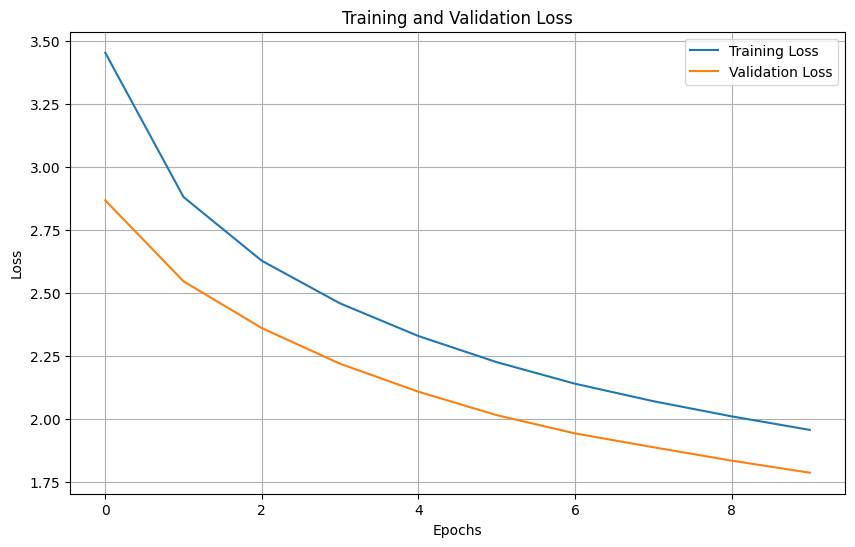

In [ ]:
plot_training_history(history)

In [ ]:
def predict_translation(model, tokenizer, text, prefix="translate English to Indonesian: "):
    input_text = prefix + text
    input_ids = tokenizer(input_text, return_tensors="tf", truncation=True).input_ids
    output = model.generate(input_ids)
    translation = tokenizer.decode(output[0], skip_special_tokens=True)
    return translation

In [ ]:
text = "I love reading book"

print(predict_translation(model, tokenizer, text))

Aku suka mengajar buku
